Combining VAE and GAN for our stl files. Below codes are mainly based on https://github.com/Spartey/3D-VAE-GAN-Deep-Learning-Project/tree/master/3D-VAE-WGAN

Our input is mesh format, 1 dimensional (reshaped) or 2 dimensional (matrix for triangles) not 3 dimenional as in the reference code.

**Issues/Questions:**

1. use tanh not relu for stl file?

### Environment Setup

In [1]:
import os, time, itertools
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
# import getTrain

# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

### Import Data

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data import THINGI10K_INDEX
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh

thingi = Thingi10k.init10()
n_samples = len(thingi)
n_samples

10

In [3]:
# some models are quite large and cause this architecture to hit a memory error
# also tensors cannot be greater than 2 GB!
# to calculate size in bytes of tensor, take size of architecture layer * vector length * 4

#n_input = 90000  # multiple of 9!! vertices come in 3! any less and you're cutting off vital info
n_input = thingi.max_length()

print('n_samples: {}'.format(n_samples))
print('n_input: {}'.format(n_input))
size_bytes = n_input * 100 * 4
print('size: {} bytes'.format(size_bytes))
size_gb = size_bytes / 1024 / 1024 / 1024
print('size: {:.2f} gb'.format(size_bytes / 1024 / 1024 / 1024))
assert size_gb < 2

n_samples: 10
n_input: 276048
size: 110419200 bytes
size: 0.10 gb


### Configuration

In [4]:
batch_size = 5
D_lr = 5e-5
G_lr = 1e-4
train_epoch = 20
n_latent = 50
alpha_1 = 5  ### weight for VAE loss function, KL Divergence loss
alpha_2 = 5e-4 ### weight for VAE loss function, reconstruction loss

### Models

In [5]:
### not used ?
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
## first test our 1-d input, filter size uses 3 not 4?
def encoder(x, keep_prob=0.5, isTrain=True):
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE): 
        conv1 = tf.layers.conv1d(x, 128, [4], strides=2, padding='same'
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        lrelu1 = tf.nn.elu(conv1)

        conv2 = tf.layers.conv1d(lrelu1, 256, [4], strides=2, padding='same'
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))
        
        conv3 = tf.layers.conv1d(lrelu2, 512, [4], strides=2, padding='same'
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        conv4 = tf.layers.conv1d(lrelu3, 1024, [4], strides=2, padding='same'
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=isTrain))

        conv5 = tf.layers.conv1d(lrelu4, 32, [4], strides=2, padding='valid'
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv5, training=isTrain))

        x = tf.nn.dropout(lrelu5, keep_prob)
        x = tf.contrib.layers.flatten(x)
        z_mu = tf.layers.dense(x, units=n_latent)
        z_sig = 0.5 * tf.layers.dense(x, units=n_latent)
#         epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]))
        epsilon = tf.random_normal((tf.shape(x)[0], n_latent))
         # z = mu + sigma*epsilon
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        
        print("conv1 shape: ",conv1.shape)
        print("lrelu1 shape: ",lrelu1.shape)
        print("conv2 shape: ",conv2.shape)
        print("lrelu2 shape: ",lrelu2.shape)
        print("conv3 shape: ",conv3.shape)
        print("lrelu3 shape: ",lrelu3.shape)
        print("conv4 shape: ",conv4.shape)
        print("lrelu4 shape: ",lrelu4.shape)
        print("conv5 shape: ",conv5.shape)
        print("lrelu5 shape: ",lrelu5.shape)
        print("x shape: ", x.shape)
        print("z_mu shape: ", z_mu.shape)
        print("z_sig shape:", z_sig.shape)
        print("eps shape: ", epsilon.shape)
        print("z shape: ", z.shape)

        return z, z_mu, z_sig
    
    # should use transpose for generator? CNN not working
def generator(x, isTrain=True):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        # 1st hidden layer
        conv1 = tf.layers.conv1d(x, 256, [2], strides=1, padding='same', use_bias=False
                                           , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=isTrain))

        # 2nd hidden layer
        conv2 = tf.layers.conv1d(lrelu1, 128, [2], strides=1, padding='same', use_bias=False
                                           , kernel_initializer=tf.contrib.layers.xavier_initializer()) 
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        conv3 = tf.layers.conv1d(lrelu2, 64, [2], strides=1, padding='same', use_bias=False
                                           , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))
         # 4th hidden layer
        conv4 = tf.layers.conv1d(lrelu3, 32, [2], strides=1, padding='same', use_bias=False
                                           , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=isTrain))
        # output layer
        conv5 = tf.layers.conv1d(lrelu4, 1, [2], strides=1, padding='valid', use_bias=False
                                           , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        o = tf.nn.tanh(conv5)
        o = tf.nn.tanh(lrelu4)
        
        print("conv1 shape: ",conv1.shape)
        print("lrelu1 shape: ",lrelu1.shape)
        print("conv2 shape: ",conv2.shape)
        print("lrelu2 shape: ",lrelu2.shape)
        print("conv3 shape: ",conv3.shape)
        print("lrelu3 shape: ",lrelu3.shape)
        print("conv4 shape: ",conv4.shape)
        print("lrelu4 shape: ",lrelu4.shape)
        print("conv5 shape: ",conv5.shape)
        print("x shape: ", x.shape)
        print("output shape: ", o.shape)

        return o

def generator(x, isTrain=True):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
       

        G_W1 = tf.Variable(xavier_init([n_latent, 128]))
        G_b1 = tf.Variable(tf.zeros(shape=[128]))

        G_W2 = tf.Variable(xavier_init([128, n_input])) 
        G_b2 = tf.Variable(tf.zeros(shape=[n_input]))

        G_h1 = tf.nn.relu(tf.matmul(x, G_W1) + G_b1)
        G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
        G_prob = tf.nn.sigmoid(G_log_prob)
        
        print("output shape: ", G_prob.shape)
        
        return G_prob




def discriminator(x, isTrain=True):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):  
        # 1st hidden layer
        conv1 = tf.layers.conv1d(x, 128, [4], strides=(2), padding='same', use_bias=False
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu1 = tf.nn.elu(conv1)
        # 2nd hidden layer
        conv2 = tf.layers.conv1d(lrelu1, 256, [4], strides=(2), padding='same', use_bias=False
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=isTrain))

        # 3rd hidden layer
        conv3 = tf.layers.conv1d(lrelu2, 512, [4], strides=(2), padding='same', use_bias=False
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())  
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=isTrain))

        # output layer
        conv4 = tf.layers.conv1d(lrelu3, 1, [4], strides=(1), padding='valid', use_bias=False
                                 , kernel_initializer=tf.contrib.layers.xavier_initializer())
        o = tf.nn.sigmoid(conv4)

        return o, conv4

In [7]:
# variables : input

x_1D = tf.placeholder(tf.float32, shape=(None, n_input, 1))

keep_prob = tf.placeholder(dtype=tf.float32)
isTrain = tf.placeholder(dtype=tf.bool)

# networks : encoder
z, z_mu, z_sig = encoder(x_1D, keep_prob, isTrain)

# z = tf.reshape(z, (-1, 1, n_latent))

# networks : generator
G_z = generator(z, isTrain)

# # networks : discriminator
D_real, D_real_logits = discriminator(x_1D, isTrain)
G_z = tf.reshape(G_z, (-1, n_input, 1))
D_fake, D_fake_logits = discriminator(G_z, isTrain)

conv1 shape:  (?, 138024, 128)
lrelu1 shape:  (?, 138024, 128)
conv2 shape:  (?, 69012, 256)
lrelu2 shape:  (?, 69012, 256)
conv3 shape:  (?, 34506, 512)
lrelu3 shape:  (?, 34506, 512)
conv4 shape:  (?, 17253, 1024)
lrelu4 shape:  (?, 17253, 1024)
conv5 shape:  (?, 8625, 32)
lrelu5 shape:  (?, 8625, 32)
x shape:  (?, 276000)
z_mu shape:  (?, 50)
z_sig shape: (?, 50)
eps shape:  (?, 50)
z shape:  (?, 50)
output shape:  (?, 276048)


In [8]:
# loss for each network

# reconstruction_loss = tf.reduce_sum(tf.squared_difference(tf.reshape(G_z, (-1, 32 * 32 * 32))
#                                                           , tf.reshape(x_3D, (-1, 32 * 32 * 32))),
#                                     1)
reconstruction_loss = tf.reduce_sum(tf.squared_difference(G_z, x_1D), 1)

KL_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)
mean_KL = tf.reduce_sum(KL_divergence)
mean_recon = tf.reduce_sum(reconstruction_loss)

VAE_loss = tf.reduce_mean(alpha_1 * KL_divergence + alpha_2 * reconstruction_loss)

### GAN loss
D_loss_real = tf.reduce_mean(D_real_logits)


D_loss_fake = tf.reduce_mean(D_fake_logits)
D_loss = D_loss_real - D_loss_fake
G_loss = -tf.reduce_mean(D_fake_logits)
# sub_loss = G_loss + VAE_loss

tf.summary.scalar('D_loss', D_loss)
tf.summary.scalar('G_loss', G_loss)

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]
E_vars = [var for var in T_vars if var.name.startswith('encoder')]

clip = [p.assign(tf.clip_by_value(p, -0.5, 0.5)) for p in D_vars]


# optimizer for each network
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.RMSPropOptimizer(D_lr).minimize(-D_loss, var_list=D_vars)
    G_optim = tf.train.RMSPropOptimizer(G_lr).minimize(G_loss, var_list=G_vars)
    E_optim = tf.train.AdamOptimizer(G_lr).minimize(VAE_loss, var_list=E_vars)
    # E_optim = tf.train.RMSPropOptimizer(lr).minimize(VAE_loss, var_list=E_vars)

In [9]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

logger = tf.summary.FileWriter('./graphs', sess.graph)
merged = tf.summary.merge_all()

# # load dataset
# image_path = "./test_image/"
# model_path = "./test_model/"
root = "./result_test/"
# dataset = getTrain.getData(image_path, model_path)

if os.path.isdir(root) is False:
    os.mkdir(root)

model_path = './network_test/'
if os.path.isdir(model_path) is False:
    os.mkdir(model_path)
saver = tf.train.Saver()

Iteration: 0
D Loss: -0.04260049
G Loss: 0.092756055
VAE loss: 340.1703
KL divergence: 322.90314
reconstruction_loss: 172671.28
###########


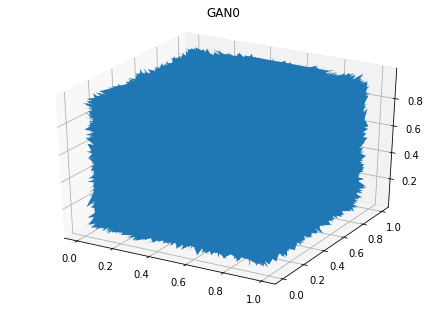

Iteration: 0
D Loss: 0.07340993
G Loss: 0.093854375
VAE loss: 488.6489
KL divergence: 469.73553
reconstruction_loss: 189133.6
###########


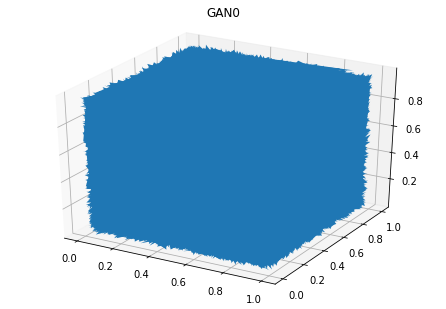

Iteration: 20
D Loss: 1.1414402
G Loss: 0.4724211
VAE loss: 1173.2332
KL divergence: 1160.7195
reconstruction_loss: 125136.805
###########


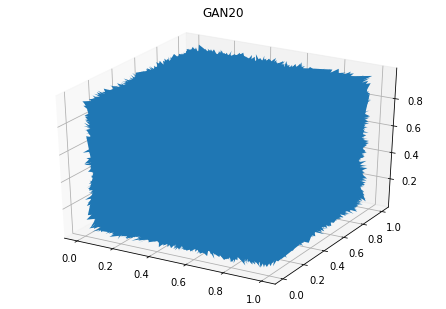

Iteration: 20
D Loss: 0.8748317
G Loss: 0.49954253
VAE loss: 162.75542
KL divergence: 150.02734
reconstruction_loss: 127280.52
###########


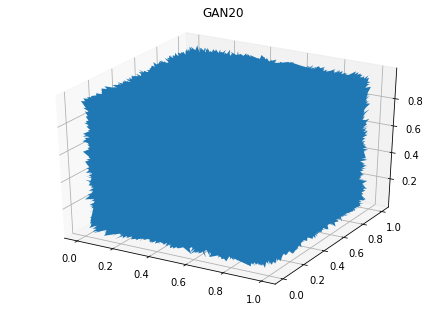

Iteration: 40
D Loss: 1.6301044
G Loss: 0.79242337
VAE loss: 116.64761
KL divergence: 104.7502
reconstruction_loss: 118974.3
###########


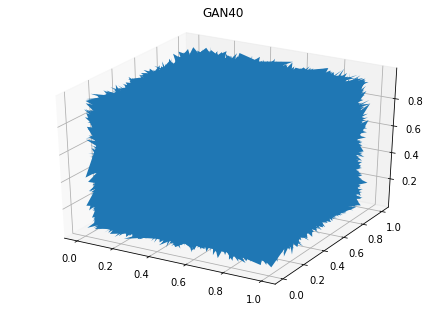

Iteration: 60
D Loss: 2.6223836
G Loss: 0.8325825
VAE loss: 485.86484
KL divergence: 473.01813
reconstruction_loss: 128467.42
###########


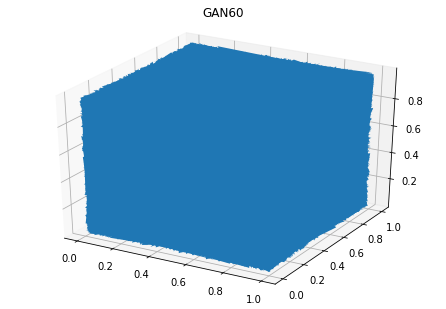

Iteration: 60
D Loss: 2.4154673
G Loss: 0.85877705
VAE loss: 125.5259
KL divergence: 111.56725
reconstruction_loss: 139586.48
###########


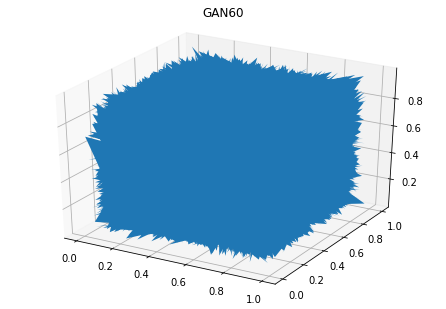

Iteration: 80
D Loss: 3.4853973
G Loss: 0.67214215
VAE loss: 558.7658
KL divergence: 542.51886
reconstruction_loss: 162470.06
###########


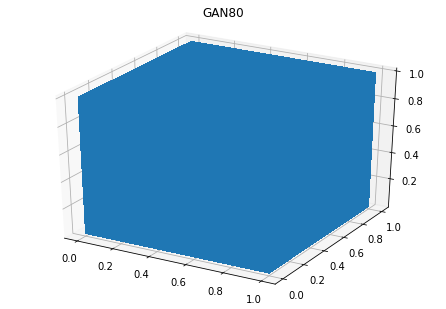

Iteration: 80
D Loss: 3.2529001
G Loss: 0.67399544
VAE loss: 123.33181
KL divergence: 109.73891
reconstruction_loss: 135928.9
###########


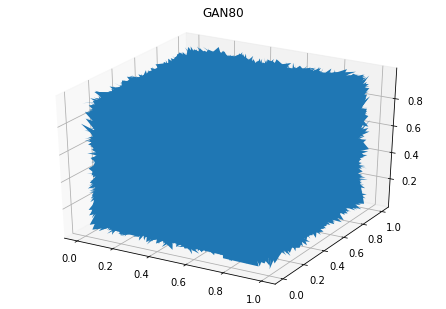

In [ ]:
# training-loop
num = 0
for it in range(100):

    for x_1d in thingi.batchmaker(batch_size=batch_size, normalize=True, flat=True, pad_length=n_input, filenames=False):

        x_1d = x_1d.reshape([-1, n_input, 1])

        for _ in range(4):
            sess.run(D_optim, feed_dict={x_1D: x_1d, keep_prob: 0.8, isTrain: True})
            sess.run(clip)
        
        loss_d_, loss_g_, _VAE_loss, _KL_divergence, _reconstruction_loss, summary, _, _, _ = \
            sess.run([D_loss, G_loss, VAE_loss, mean_KL, mean_recon, merged, D_optim, G_optim, E_optim],
                     {x_1D: x_1d, keep_prob: 0.8, isTrain: True})
        
        sess.run(clip)
        
        if it % 20 == 0:
            print("Iteration:", it)
            print("D Loss:", loss_d_)
            print("G Loss:", loss_g_)
            print("VAE loss:", _VAE_loss)
            print("KL divergence:", _KL_divergence)
            print("reconstruction_loss:", _reconstruction_loss)
            print("###########")
                
            if it % 20 == 0:
                G = sess.run(G_z, feed_dict={x_1D: x_1d, keep_prob: 1, isTrain: False})
                np.save(root + str(it) + ".npy", G)
                x_reconstruct_vectors = G.reshape([-1, 3, 3])
                plot_mesh(x_reconstruct_vectors, title='GAN'+str(it))
                save_vectors_as_stl(x_reconstruct_vectors, 'vae_gan_stl_'+str(it)+'.stl')
                
                if it % 1000 == 0:
                    saver.save(sess, model_path + str(it) + ".ckpt")

sess.close()
